In [1]:
import pandas as pd
import sklearn.metrics
import tensorflow as tf
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from definitions import ROOT_DIR, main_activity_label_classes
from trainTestValSplit import getTrainTestValSplit
from preProcessing import preProcess
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sn

In [56]:
train_concat, test_concat, val_concat = getTrainTestValSplit(
    _dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/Processed'
)

In [109]:
train_x, train_y = preProcess(train_concat)
test_x, test_y = preProcess(test_concat)
val_x, val_y = preProcess(val_concat)

columns = train_x.columns
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)
val_x = val_x.fillna(0)

#remove the most n redundant features
model = ExtraTreesClassifier()
model.fit(train_x,train_y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=columns)
for x in feat_importances.nsmallest(150).keys():
    train_x.drop(x,1)
    test_x.drop(x,1)
    val_x.drop(x,1)

train_x.drop('label_source',1)
val_x.drop('label_source',1)
test_x.drop('label_source',1)
n_columns = len(train_x.columns)

train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()


[6.92858584e-03 4.01297532e-03 2.46385775e-03 4.04285355e-03
 7.21354425e-03 7.32645334e-03 7.08885001e-03 4.70409644e-03
 3.10231216e-03 2.19283554e-03 2.13013604e-03 5.86936500e-03
 4.41603109e-03 3.93426156e-03 2.74173628e-03 2.27509220e-03
 3.82360463e-03 6.87353619e-03 8.58601366e-03 9.50396274e-03
 3.39758817e-03 3.72031025e-03 3.95799134e-03 2.59033507e-03
 2.55672960e-03 2.80044161e-03 4.72705206e-03 3.46506111e-03
 2.92062153e-03 2.93021927e-03 5.52222502e-03 5.77169353e-03
 5.26948436e-03 4.52565593e-03 3.15474765e-03 2.73448405e-03
 4.44876983e-03 3.76824950e-03 3.10812353e-03 4.00530611e-03
 4.29723091e-03 1.99160673e-03 2.46985387e-03 2.47746097e-03
 2.57734072e-03 2.44715816e-03 4.36745352e-03 4.25328609e-03
 3.19610788e-03 3.39979916e-03 2.77099464e-03 2.89173683e-03
 9.90659836e-03 2.49848877e-03 2.11284394e-03 2.46382199e-03
 9.75055423e-03 9.55502789e-03 9.63164685e-03 3.04859741e-03
 3.77736293e-03 1.80716205e-03 2.10526039e-03 2.48299768e-03
 3.01444265e-03 4.565392

C:\Users\Bo Sterenborg\AppData\Local\Temp\ipykernel_12656\1935316710.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_x.drop(x,1)
C:\Users\Bo Sterenborg\AppData\Local\Temp\ipykernel_12656\1935316710.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_x.drop(x,1)
C:\Users\Bo Sterenborg\AppData\Local\Temp\ipykernel_12656\1935316710.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  val_x.drop(x,1)
C:\Users\Bo Sterenborg\AppData\Local\Temp\ipykernel_12656\1935316710.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_x.drop(x,1)
C:\Users\Bo Sterenborg\AppData\Local\Temp\ipykernel_12656\1935316710.py:17: FutureWarning: 

In [121]:
n_neurons: int = 1024
window_size: int = 10
epochs: int = 100
n_y: int = len(main_activity_label_classes)
batch_size: int = 128
n_features: int = n_columns

In [111]:
# Source: https://stackoverflow.com/questions/43114460/is-there-a-way-to-reshape-an-array-that-does-not-maintain-the-original-size-or
def reshape_and_truncate(arr, shape):
    desired_size_factor = np.prod([n for n in shape if n != -1])
    if -1 in shape:  # implicit array size
        desired_size = arr.size // desired_size_factor * desired_size_factor
    else:
        desired_size = desired_size_factor
    return arr.flat[:desired_size].reshape(shape)

In [112]:
def encodeTarget(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    return np_utils.to_categorical(y)

In [113]:
train_y = encodeTarget(train_y)
test_y = encodeTarget(test_y)
val_y = encodeTarget(val_y)

In [114]:
train_x = reshape_and_truncate(train_x, (-1, window_size, n_features))
train_y = reshape_and_truncate(train_y, (-1, window_size, len(main_activity_label_classes)))

test_x = reshape_and_truncate(test_x, (-1, window_size, n_features))
test_y = reshape_and_truncate(test_y, (-1, window_size, len(main_activity_label_classes)))

val_x = reshape_and_truncate(val_x, (-1, window_size, n_features))
val_y = reshape_and_truncate(val_y, (-1, window_size, len(main_activity_label_classes)))

In [122]:
with tf.device('/cpu:0'):
    model = tf.keras.Sequential()

    layer = tf.keras.layers.Normalization(axis=-1)
    layer.adapt(train_x)
    model.add(layer)
    model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.LSTM(16, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_y, activation=tf.keras.activations.softmax))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=
                  tf.keras.optimizers.Adam(
    learning_rate=0.0001,
)
, metrics=['acc'])
    # model.summary()
    history = model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size,
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode='auto', restore_best_weights=True)])
    predict = model.predict(test_x)

Epoch 1/100
179/179 [==============================] - 9s 31ms/step - loss: 1.8055 - acc: 0.3555 - val_loss: 1.6266 - val_acc: 0.5626
Epoch 2/100
179/179 [==============================] - 5s 30ms/step - loss: 1.4858 - acc: 0.5520 - val_loss: 1.3200 - val_acc: 0.6296
Epoch 3/100
179/179 [==============================] - 5s 30ms/step - loss: 1.3028 - acc: 0.5888 - val_loss: 1.1907 - val_acc: 0.6473
Epoch 4/100
179/179 [==============================] - 5s 31ms/step - loss: 1.1970 - acc: 0.6168 - val_loss: 1.1215 - val_acc: 0.6724
Epoch 5/100
179/179 [==============================] - 5s 30ms/step - loss: 1.1065 - acc: 0.6568 - val_loss: 1.0683 - val_acc: 0.6887
Epoch 6/100
179/179 [==============================] - 5s 30ms/step - loss: 1.0257 - acc: 0.6920 - val_loss: 1.0265 - val_acc: 0.6965
Epoch 7/100
179/179 [==============================] - 5s 30ms/step - loss: 0.9631 - acc: 0.7152 - val_loss: 0.9910 - val_acc: 0.7048
Epoch 8/100
179/179 [==============================] - 5s 30ms

In [116]:
def get_labels(windows):
    predicted_labels = []

    for p in windows:
        df = pd.DataFrame(p)
        probabilities = []

        for col in df.columns:
            probabilities.append(df[col].mean())
        predicted_labels.append(np.argmax(probabilities))
    return predicted_labels

In [123]:
gold_labels = get_labels(test_y)
predicted_labels = get_labels(predict)

In [124]:
f1_score(gold_labels, predicted_labels, average='weighted')

0.7385452702468887

In [125]:
tf.math.confusion_matrix(gold_labels, predicted_labels)

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[ 770,    2,  132,   30,    5,    0,    0],
       [   4, 1025,  126,   78,    0,    0,    0],
       [  18,  119, 1759,  198,   47,    0,    1],
       [   9,   35,  298,  153,   30,    0,    0],
       [   7,   10,   95,   55,  150,    0,    0],
       [   0,    0,    2,   11,    5,    0,    0],
       [   3,    0,    9,    4,   15,    0,    4]])>

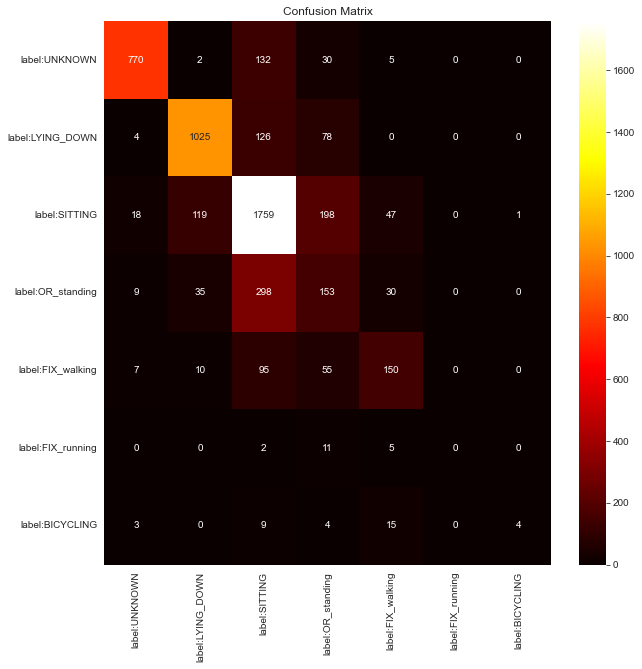

In [126]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix')
sn.heatmap(
    pd.DataFrame(tf.math.confusion_matrix(gold_labels, predicted_labels), index=main_activity_label_classes.keys(),
                 columns=main_activity_label_classes.keys()), annot=True, fmt='d', cmap='hot')
plt.savefig('confusion_matrix_lstm.png')

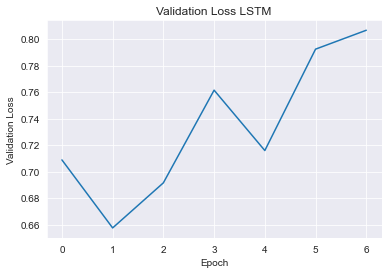

In [106]:
val_loss = history.history['val_loss']
plt.plot(val_loss)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss LSTM')
plt.savefig('convergence_val_loss_lstm.png')